In [68]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from tqdm import tqdm

rho_values = np.linspace(0, 0.95, 20) # auto correlation range
alpha_levels = np.linspace(0.01, 0.3, 30) # significance values
n = 1000
iterations = 1000  

type_1_errors = np.zeros((len(alpha_levels), len(rho_values)))
type_2_errors = np.zeros((len(alpha_levels), len(rho_values)))

In [69]:
for i, alpha in tqdm(enumerate(alpha_levels)):
    for j, rho in enumerate(rho_values):
        t1_error_count = 0
        t2_error_count = 0
        ar_params = np.array([1, -rho])
        ma_params = np.array([1])
        arma_process = ArmaProcess(ar_params, ma_params)
        
        for _ in range(iterations):
            # 귀무 가설 하에 데이터 생성
            simulated_data = arma_process.generate_sample(nsample=n)
            x = np.linspace(0, 10, n)
            X = add_constant(x)
            y_null = simulated_data  # 귀무 가설 하에서의 데이터
            model_null = OLS(y_null, X).fit()
            p_value_null = model_null.pvalues[1]
            
            # 1종 오류 계산
            if p_value_null < alpha:
                t1_error_count += 1

            # 대안 가설 하에 데이터 생성 (실제 효과 추가)
            y_alt = simulated_data + 0.03 * x  # 효과 추가
            model_alt = OLS(y_alt, X).fit()
            p_value_alt = model_alt.pvalues[1]
            
            # 2종 오류 계산
            if p_value_alt > alpha:
                t2_error_count += 1
        
        type_1_errors[i, j] = t1_error_count / iterations
        type_2_errors[i, j] = t2_error_count / iterations

30it [09:33, 19.12s/it]


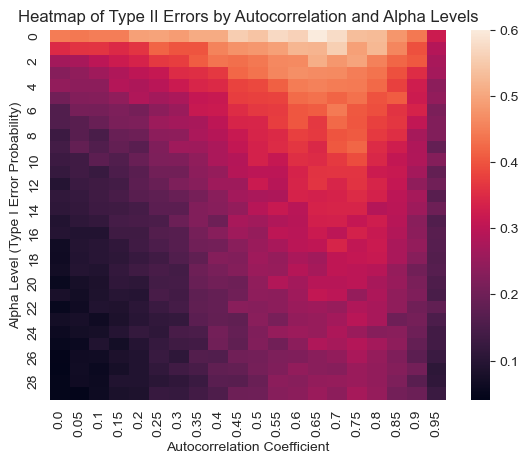

In [70]:
sns.heatmap(
    type_2_errors,
    xticklabels = np.round(rho_values, 2), 
    annot=False
)

plt.title('Heatmap of Type II Errors by Autocorrelation and Alpha Levels')
plt.xlabel('Autocorrelation Coefficient')
plt.ylabel('Alpha Level (Type I Error Probability)')
plt.show()

In [71]:
import pandas as pd
alpha_frame = pd.DataFrame(type_1_errors, columns = np.round(rho_values, 2), index = np.round(alpha_levels,3))
beta_frame = pd.DataFrame(type_2_errors, columns = np.round(rho_values, 2), index = np.round(alpha_levels,3))

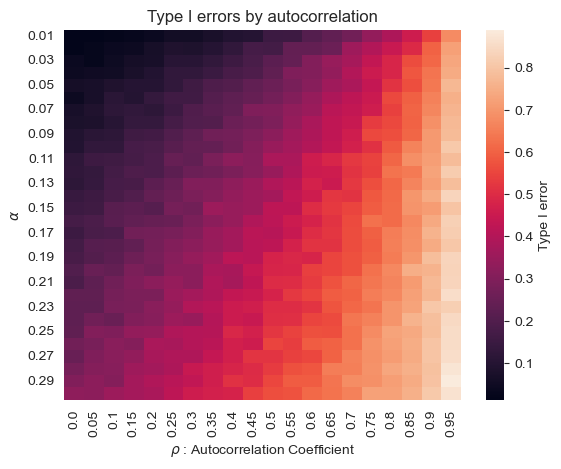

In [72]:
sns.heatmap(alpha_frame, cbar_kws = {'label' : 'Type I error'})
plt.xlabel(r'$\rho$ : Autocorrelation Coefficient')
plt.ylabel(r'$\alpha$')
plt.title('Type I errors by autocorrelation')
plt.show()

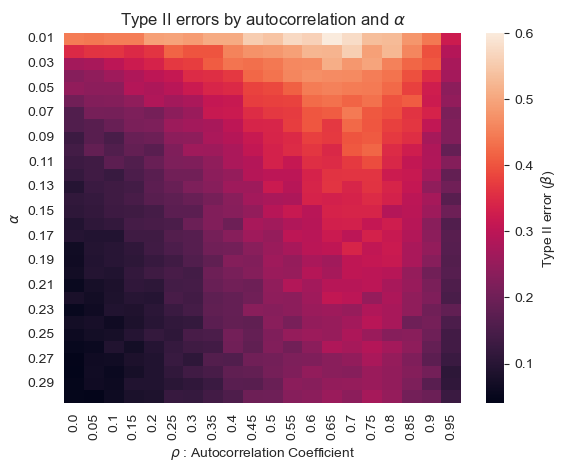

In [73]:
sns.heatmap(beta_frame, cbar_kws = {'label' : r'Type II error ($\beta$)'})
plt.xlabel(r'$\rho$ : Autocorrelation Coefficient')
plt.ylabel(r'$\alpha$')
plt.title(r'Type II errors by autocorrelation and $\alpha$')
plt.show()